In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for better aesthetics
sns.set_theme(style="whitegrid")

In [2]:
# --- Configuration ---
INPUT_FILE = "../data/raw/Database_CPT_PremstallerGeotechnik/CPT_PremstallerGeotechnik_revised.csv" 
# -------------------

# Load the dataset
try:
    df = pd.read_csv(INPUT_FILE)
    print("File loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at '{INPUT_FILE}'. Please check the path.")

# Display the first few rows to understand the format
print("First 5 rows of the dataset:")
display(df.head())

# Get a concise summary of the dataframe
print("\nDataset Info:")
df.info()

# Get summary statistics for numerical columns
print("\nSummary Statistics:")
display(df.describe())

/tmp/ipykernel_13499/2953689304.py:7: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


File loaded successfully!
First 5 rows of the dataset:


,ID,test_type,basin_valley,Depth (m),qc (MPa),fs (kPa),u2 (kPa),Vs (m/s),qt (MPa),Rf (%),...,U2 (-),SBT (-),SBTn (-),Mod. SBTn (-),n,Ic (-),Ic SBT (-),Ib (-),EN_ISO_14688_classes,Oberhollenzer_classes
0,0,CPT,Zell basin,0.02,1.15,1.0,NaN,NaN,1.77,0.06,...,NaN,0.0,0.0,0.0,-0.12,2.56,2.23,25.61,NaN,NaN
1,0,CPT,Zell basin,0.04,2.85,1.0,NaN,NaN,2.99,0.03,...,NaN,0.0,0.0,0.0,0.33,1.23,2.02,256.60,NaN,NaN
2,0,CPT,Zell basin,0.06,4.80,1.0,NaN,NaN,4.76,0.06,...,NaN,0.0,0.0,0.0,0.28,1.16,1.80,264.66,NaN,NaN
3,0,CPT,Zell basin,0.08,6.40,6.0,NaN,NaN,6.12,0.07,...,NaN,0.0,0.0,0.0,0.27,1.12,1.69,275.17,NaN,NaN
4,0,CPT,Zell basin,0.10,6.90,6.0,NaN,NaN,6.91,0.10,...,NaN,0.0,0.0,0.0,0.27,1.11,1.65,267.92,NaN,NaN



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516979 entries, 0 to 2516978
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     int64  
 1   test_type              object 
 2   basin_valley           object 
 3   Depth (m)              float64
 4   qc (MPa)               float64
 5   fs (kPa)               float64
 6   u2 (kPa)               float64
 7   Vs (m/s)               float64
 8   qt (MPa)               float64
 9   Rf (%)                 float64
 10  γ (kN/m³)              float64
 11  σ,v (kPa)              float64
 12  u0 (kPa)               float64
 13  σ',v (kPa)             float64
 14  Qt (-)                 float64
 15  Qtn (-)                float64
 16  Fr (%)                 float64
 17  Bq (-)                 float64
 18  U2 (-)                 float64
 19  SBT (-)                float64
 20  SBTn (-)               float64
 21  Mod. SBTn (-)          float64
 22  n  

,ID,Depth (m),qc (MPa),fs (kPa),u2 (kPa),Vs (m/s),qt (MPa),Rf (%),γ (kN/m³),"σ,v (kPa)",...,Bq (-),U2 (-),SBT (-),SBTn (-),Mod. SBTn (-),n,Ic (-),Ic SBT (-),Ib (-),Oberhollenzer_classes
count,2.516979e+06,2.516979e+06,2.516162e+06,2.515446e+06,798379.000000,3981.000000,2.516853e+06,2.515663e+06,2516852.0,2.516852e+06,...,798424.000000,798429.000000,2.516853e+06,2.516851e+06,2.516851e+06,2.516851e+06,2.516851e+06,2.516852e+06,2.514622e+06,880960.000000
mean,6.982726e+02,1.239890e+01,5.562390e+00,6.443692e+01,248.580379,259.232605,5.582000e+00,2.696282e+00,19.0,2.355694e+02,...,0.236024,0.612548,4.363366e+00,4.265981e+00,4.335774e+00,8.138722e-01,2.484708e+00,2.428181e+00,5.549533e+01,4.399736
std,3.924927e+02,1.043221e+01,8.484159e+00,2.538930e+02,356.498974,141.898354,8.475563e+00,4.327032e+01,0.0,1.982078e+02,...,1.607870,2.054080,1.491604e+00,1.705077e+00,2.382203e+00,2.033583e-01,8.083663e-01,7.272023e-01,3.915992e+02,2.286341
min,0.000000e+00,0.000000e+00,-8.610000e+00,-1.000000e+02,-96.800000,0.000000,-8.630000e+00,-1.000000e+02,19.0,1.900000e-01,...,-81.050000,-50.660000,0.000000e+00,0.000000e+00,0.000000e+00,-1.400000e-01,0.000000e+00,0.000000e+00,-9.961000e+01,0.000000
25%,3.550000e+02,4.800000e+00,1.000000e+00,1.665000e+01,8.000000,186.000000,1.030000e+00,6.700000e-01,19.0,9.120000e+01,...,0.000000,-0.230000,3.000000e+00,3.000000e+00,2.000000e+00,6.700000e-01,1.990000e+00,2.000000e+00,1.728000e+01,2.000000
50%,7.050000e+02,1.021000e+01,2.640000e+00,3.420000e+01,99.300000,238.000000,2.650000e+00,1.370000e+00,19.0,1.939900e+02,...,0.000000,0.030000,4.000000e+00,4.000000e+00,5.000000e+00,8.700000e-01,2.470000e+00,2.460000e+00,2.902000e+01,5.000000
75%,1.051000e+03,1.715000e+01,6.260000e+00,7.020000e+01,347.200000,291.000000,6.290000e+00,2.510000e+00,19.0,3.258500e+02,...,0.310000,1.560000,6.000000e+00,6.000000e+00,7.000000e+00,1.000000e+00,3.140000e+00,2.910000e+00,5.485000e+01,6.000000
max,1.338000e+03,1.030000e+02,1.229000e+02,4.743600e+04,2381.300000,1310.000000,1.198200e+02,3.000000e+04,19.0,1.957000e+03,...,1095.470000,414.600000,9.000000e+00,9.000000e+00,7.000000e+00,1.000000e+00,4.060000e+00,2.876000e+01,4.998024e+04,7.000000


In [3]:
# Analyze the number of unique CPT tests
unique_cpts = df['ID'].unique()
print(f"Total number of unique CPTs: {len(unique_cpts)}")

# Analyze the depth and measurement counts for each CPT
cpt_lengths = df.groupby('ID').size()
print("\nDistribution of CPT lengths (number of measurements):")
display(cpt_lengths.describe())

Total number of unique CPTs: 1339

Distribution of CPT lengths (number of measurements):


count     1339.000000
mean      1879.745332
std       1060.419943
min         32.000000
25%       1134.500000
50%       2000.000000
75%       2253.000000
max      10300.000000
dtype: float64

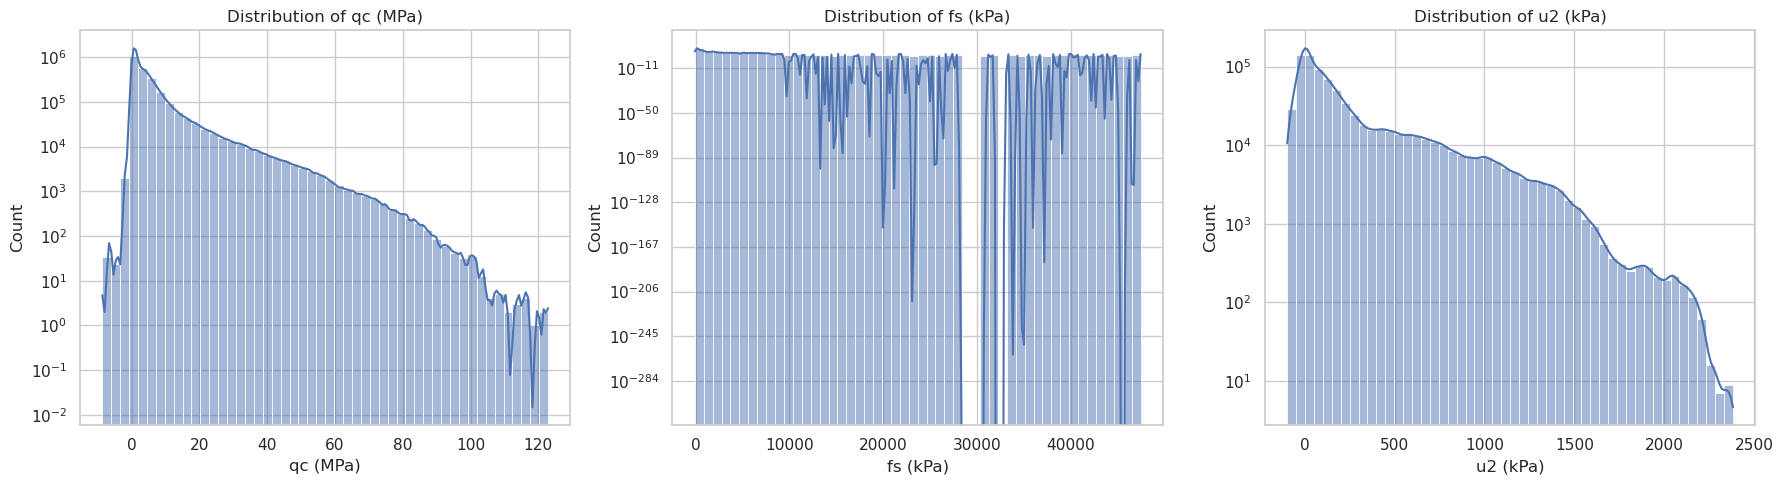

In [ ]:
# Define key feature columns
feature_cols = ['qc (MPa)', 'fs (kPa)', 'u2 (kPa)']

# Plot histograms for each key feature
plt.figure(figsize=(18, 5))
for i, col in enumerate(feature_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.yscale('log') # Use log scale due to high skewness
plt.tight_layout()
plt.show()

# Plot boxplots to see outliers more clearly
plt.figure(figsize=(18, 5))
for i, col in enumerate(feature_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.yscale('log') # Use log scale to better visualize the distribution
plt.tight_layout()
plt.show()

In [ ]:
def plot_cpt_profile(df, cpt_id):
    """Plots qc, fs, and u2 against depth for a given CPT ID."""
    cpt_data = df[df['ID'] == cpt_id].sort_values(by='Depth (m)')
    
    if cpt_data.empty:
        print(f"No data found for CPT ID: {cpt_id}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
    fig.suptitle(f'CPT Profile for ID: {cpt_id}', fontsize=16)

    # Plot Cone Resistance (qc)
    axes[0].plot(cpt_data['qc (MPa)'], cpt_data['Depth (m)'], color='b')
    axes[0].set_xlabel('Cone Resistance, qc (MPa)')
    axes[0].set_ylabel('Depth (m)')
    axes[0].grid(True)
    
    # Plot Sleeve Friction (fs)
    axes[1].plot(cpt_data['fs (kPa)'], cpt_data['Depth (m)'], color='r')
    axes[1].set_xlabel('Sleeve Friction, fs (kPa)')
    axes[1].grid(True)
    
    # Plot Pore Pressure (u2)
    axes[2].plot(cpt_data['u2 (kPa)'], cpt_data['Depth (m)'], color='g')
    axes[2].set_xlabel('Pore Pressure, u2 (kPa)')
    axes[2].grid(True)
    
    # Invert y-axis to have depth increase downwards
    for ax in axes:
        ax.invert_yaxis()
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Plot a few example profiles ---
# Select a few IDs to visualize from the `unique_cpts` array
example_ids = unique_cpts[:3] # Plot the first 3 CPTs in the dataset

for test_id in example_ids:
    plot_cpt_profile(df, test_id)

In [ ]:
# Select a subset of interesting numerical columns for correlation analysis
corr_cols = [
    'Depth (m)', 'qc (MPa)', 'fs (kPa)', 'u2 (kPa)', 'qt (MPa)', 
    'Rf (%)', 'γ (kN/m³)', "σ',v (kPa)", 'Qtn (-)', 'Fr (%)', 'Ic (-)'
]

# Ensure all selected columns exist in the DataFrame
corr_cols_exist = [col for col in corr_cols if col in df.columns]

# Calculate the correlation matrix
correlation_matrix = df[corr_cols_exist].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of CPT Parameters')
plt.show()

In [ ]:
# --- Configuration ---
SOIL_CLASS_COLUMN = 'Oberhollenzer_classes'
# -------------------

# First, check for missing values in the soil class column
missing_classes = df[SOIL_CLASS_COLUMN].isnull().sum()
total_rows = len(df)
print(f"Missing soil class values: {missing_classes} ({missing_classes / total_rows:.2%})")

# Get the count of each unique soil class
class_counts = df[SOIL_CLASS_COLUMN].dropna().value_counts()

print("\nCounts of each soil class:")
print(class_counts)

# Visualize the distribution of soil classes with a bar chart
plt.figure(figsize=(12, 7))
sns.countplot(y=df[SOIL_CLASS_COLUMN].dropna(), order=class_counts.index)
plt.title('Frequency of Soil Classes (Oberhollenzer_classes)')
plt.xlabel('Count')
plt.ylabel('Soil Class')
plt.xscale('log') # Use a log scale if counts are highly variable
plt.grid(axis='x')
plt.show()

In [ ]:
# Create depth bins (e.g., every 5 meters)
max_depth = df['Depth (m)'].max()
depth_bins = np.arange(0, max_depth + 5, 5)
df['depth_bin'] = pd.cut(df['Depth (m)'], bins=depth_bins, right=False)

# Create a crosstab to count soil classes within each depth bin
class_depth_distribution = pd.crosstab(
    df['depth_bin'],
    df[SOIL_CLASS_COLUMN]
)

# Normalize the counts to get proportions
class_depth_proportion = class_depth_distribution.div(class_depth_distribution.sum(axis=1), axis=0)

# Plot the normalized stacked bar chart
class_depth_proportion.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='viridis')
plt.title('Proportional Distribution of Soil Classes with Depth')
plt.xlabel('Depth Range (m)')
plt.ylabel('Proportion of Soil Class')
plt.xticks(rotation=45)
plt.legend(title='Soil Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# --- Configuration ---
SOIL_CLASS_COLUMN = 'Oberhollenzer_classes'
NUMERICAL_COLS = ['qc (MPa)', 'fs (kPa)', 'u2 (kPa)']
# -------------------

# Create a clean dataframe for this analysis, dropping rows where key values are missing
analysis_df = df[[SOIL_CLASS_COLUMN] + NUMERICAL_COLS].dropna()

# Get the order of soil classes from most to least frequent for better plotting
class_order = analysis_df[SOIL_CLASS_COLUMN].value_counts().index

# Create violin plots for each numerical parameter against the soil classes
plt.figure(figsize=(20, 10))
for i, col in enumerate(NUMERICAL_COLS, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(data=analysis_df, x=SOIL_CLASS_COLUMN, y=col, order=class_order, cut=0)
    plt.title(f'Distribution of {col} by Soil Class', fontsize=14)
    plt.xlabel('Soil Class', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yscale('log') # Log scale is essential for these parameters
    plt.grid(True, which="both", ls="--")

plt.suptitle('CPT Parameter Distributions Across Soil Classes', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Take a random sample of the data to make the pair plot manageable
# Adjust the sample size based on your machine's performance
sample_size = 5000
sample_df = analysis_df.sample(n=min(sample_size, len(analysis_df)), random_state=42)

print(f"Creating a pair plot using a sample of {len(sample_df)} data points...")

# Create the pair plot
g = sns.pairplot(sample_df, hue=SOIL_CLASS_COLUMN, vars=NUMERICAL_COLS, 
                 plot_kws={'alpha': 0.6, 's': 20}, # Adjust point size and transparency
                 diag_kind='kde') # Use Kernel Density Estimate for diagonal plots

g.fig.suptitle('Pair Plot of CPT Parameters Colored by Soil Class (Sampled Data)', y=1.02)
plt.show()